# **Spatial Patterns of insect Diversity in continetal Ecuador**

## **Completeness analysis**

Author: Daning Montaño - Ocampo

# **1. Packages and libraries**

In [22]:
library(dplyr)
library(ggplot2)
library(sf)
library(iNEXT)
library(tidyr)
library(vegan)
library(tibble)
#library(doParallel)
#

# 2. Load clean data and grids

In [23]:
insects_records = read.csv("Data/Records/insects_records_clean.csv")%>%
  filter(taxonRank == c("species"))

# Transform to sf object
insects_records_sf = st_as_sf(insects_records, coords = c("decimalLongitude", "decimalLatitude"), crs = 4326)


In [24]:
grid_10km = st_read("Data/shp/grid_10km.shp")
grid_10km$id_10km = grid_10km$id


Reading layer `grid_10km' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\grid_10km.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 7268 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -81.32114 ymin: -6.003704 xmax: -74.19902 ymax: 2.31959
Geodetic CRS:  WGS 84


# 3. Join points to grids

By locating the points, we will extract ID information from the grid tables. This allows us to work on the analyses and simply join the results to the grid, making the process more efficient.

In [25]:
recors_grid_10km <- st_join(
  insects_records_sf,
  grid_10km %>% select(id),   
  join = st_within                              # inside polygons
)

head(recors_grid_10km)

Simple feature collection with 6 features and 18 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -79.73478 ymin: -1.437528 xmax: -78.87119 ymax: 0.532611
Geodetic CRS:  WGS 84
  id_record database_name database_id                         occurrenceID
1         2          BNDB  BNDB_10611 d7acf7c1-ac14-410f-a636-bb6568b11e49
2         4          BNDB  BNDB_10613 69a0389d-65cc-4d77-8c0e-d0ccc84ea7fb
3         6          BNDB  BNDB_10615 077e2a7f-7bd5-45fa-b755-c73a64708355
4         8          BNDB  BNDB_10617 431219fe-57b1-489b-aeba-cf5ea796076d
5        10          BNDB  BNDB_10619 51881f8d-794a-4847-9aa5-f67bfd4c110e
6        12          BNDB  BNDB_10622 6a39ade7-4d42-456e-b597-5f3f0f8bb09a
      basisOfRecord verbatimEventDate identifiedBy
1 PreservedSpecimen        1987-08-06  Dressler R.
2 PreservedSpecimen        2015-07-04 Bonifacii R.
3 PreservedSpecimen        2015-07-04 Bonifacii R.
4 PreservedSpecimen        2015-07-04 Bonifacii R.
5 PreservedSpecimen      

# 4. Records per 10 km grid

We calculate the number of records per 10 km grid usind id_10km

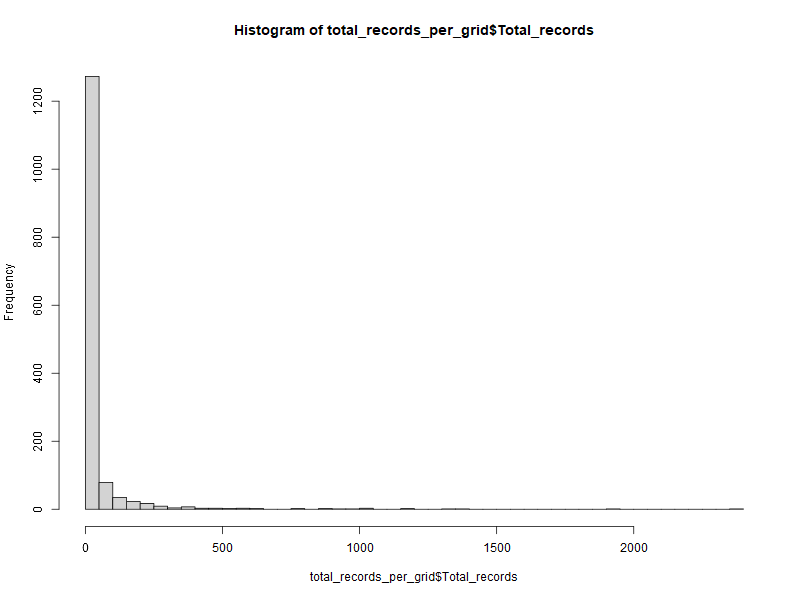

In [26]:
total_records_per_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id)%>%
  summarise(Total_records = n()) %>%
  as.data.frame()
hist(total_records_per_grid$Total_records, breaks = 50)

Join results to 10 km grid

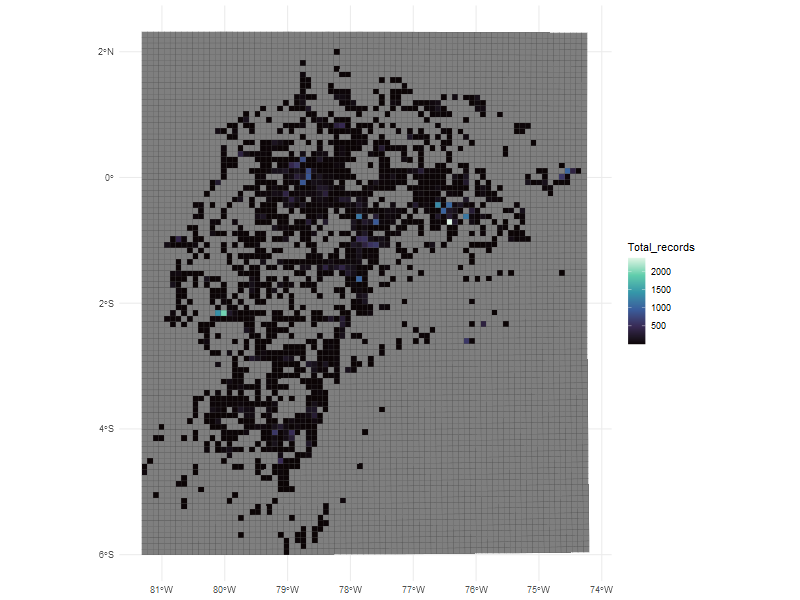

In [27]:
grid_10km = grid_10km%>% 
  left_join(total_records_per_grid, by = "id")

ggplot(grid_10km) +
  geom_sf(aes(fill = Total_records), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

# 5. Sp per 10 km grid

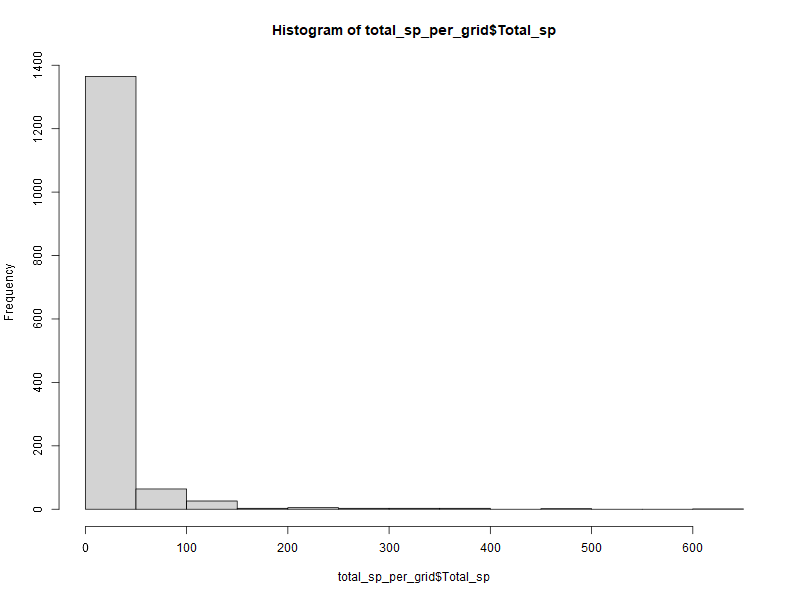

In [28]:
total_sp_per_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id)%>%
  distinct(scientificName) %>%
  summarise(Total_sp = n()) %>%
  as.data.frame()
hist(total_sp_per_grid$Total_sp)

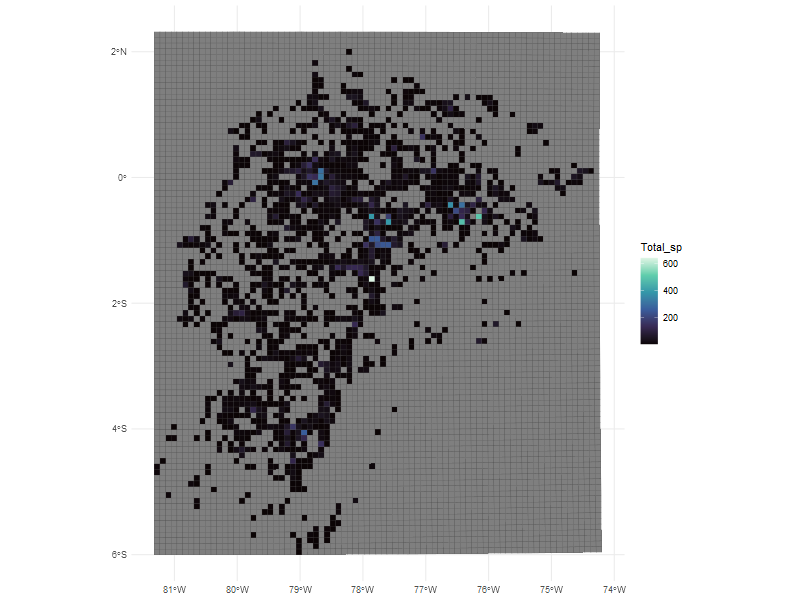

In [29]:
grid_10km = grid_10km%>% 
  left_join(total_sp_per_grid, by = "id")
ggplot(grid_10km) +
  geom_sf(aes(fill = Total_sp), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

## 5.1 Correlaction records x sp

In [30]:
cor(grid_10km$Total_records, grid_10km$Total_sp, method = "spearman", use = "complete.obs")

[1] 0.9526024

Warning messages:
1: Removed 5793 rows containing non-finite outside the scale range
(`stat_smooth()`). 
2: Removed 5793 rows containing missing values or values outside the scale range
(`geom_point()`). 


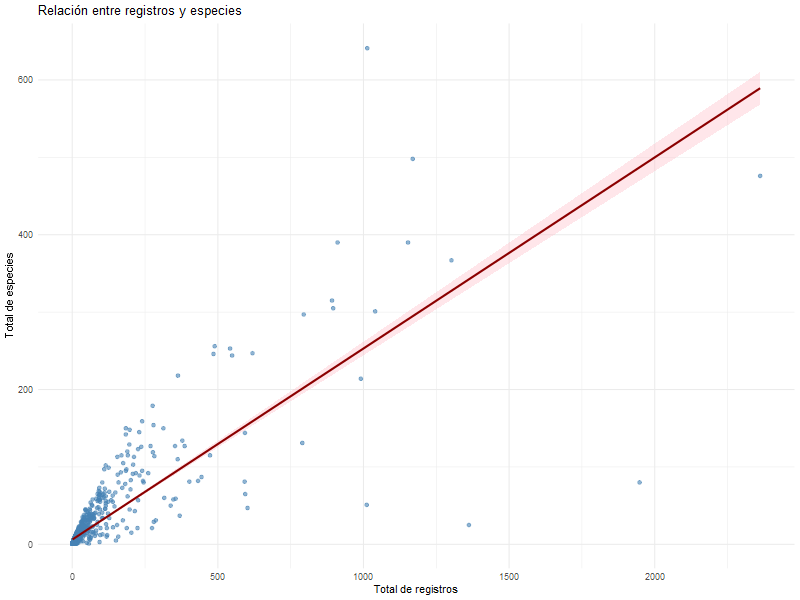

`geom_smooth()` using formula = 'y ~ x'

In [31]:
ggplot(grid_10km, aes(x = Total_records, y = Total_sp)) +
  geom_point(alpha = 0.6, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "darkred", fill = "pink") +
  theme_minimal() +
  labs(
    x = "Total de registros",
    y = "Total de especies",
    title = "Relación entre registros y especies"
  )

# 6. Sampling Completness

## 6.1. Completness - Country level

Calculate completnes for all country using incidens data and each 10 km cell is a unit

In [32]:
ecu_incidens_matrix <- recors_grid_10km %>%
  as.data.frame() %>%
  distinct(id, scientificName) %>%          # 1 por unidad-especie
  mutate(val = 1L) %>%
  pivot_wider(names_from = scientificName, values_from = val, values_fill = 0) %>%
  arrange(id)
ids_unidades_ecu <- ecu_incidens_matrix$id

# Quitamos la columna de IDs para dejar solo 0/1 por especie
incidences_ecu_df <- ecu_incidens_matrix %>% dplyr::select(-id)

# Matriz of incidences - iNext
inext_in_ecu <- list(ensamblaje = as.data.frame(t(incidences_ecu_df)))




Use iNEXT funtion to calculate the sampling coverage in Ecuador, an only extract richness (q=0) and sampling coverage

In [33]:
result_inext_ecu <- iNEXT(inext_in_ecu, q = 0, datatype = "incidence_raw", se = TRUE, conf = 0.95,nboot= 100 )
result_inext_ecu

Compare 1 assemblages with Hill number order q = 0.
$class: iNEXT

$DataInfo: basic data information
  Assemblage    T     U S.obs     SC   Q1   Q2  Q3  Q4  Q5  Q6  Q7 Q8 Q9 Q10
1 ensamblaje 1475 23563  7319 0.8331 3935 1242 615 342 243 163 120 98 79  78

$iNextEst: diversity estimates with rarefied and extrapolated samples.
$size_based (LCL and UCL are obtained for fixed size.)

   Assemblage    t        Method Order.q          qD      qD.LCL      qD.UCL
1  ensamblaje    1   Rarefaction       0    15.97492    15.76907    16.18076
10 ensamblaje  737   Rarefaction       0  4929.55601  4871.48571  4987.62631
20 ensamblaje 1475      Observed       0  7319.00000  7225.12434  7412.87566
30 ensamblaje 2174 Extrapolation       0  8930.26294  8798.69621  9061.82967
40 ensamblaje 2950 Extrapolation       0 10235.79507 10056.99009 10414.60005
            SC      SC.LCL     SC.UCL
1  0.009895179 0.009431728 0.01035863
10 0.747955994 0.743587273 0.75232472
20 0.833072380 0.828471718 0.83767304
30 

In [34]:
info_inext_ecu <- DataInfo(inext_in_ecu, datatype = "incidence_raw")  # columna SC = sample coverage; T = # unidades de muestreo
info_inext_ecu


Warning message:
In ggiNEXT.iNEXT(result_inext_ecu, type = 2) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


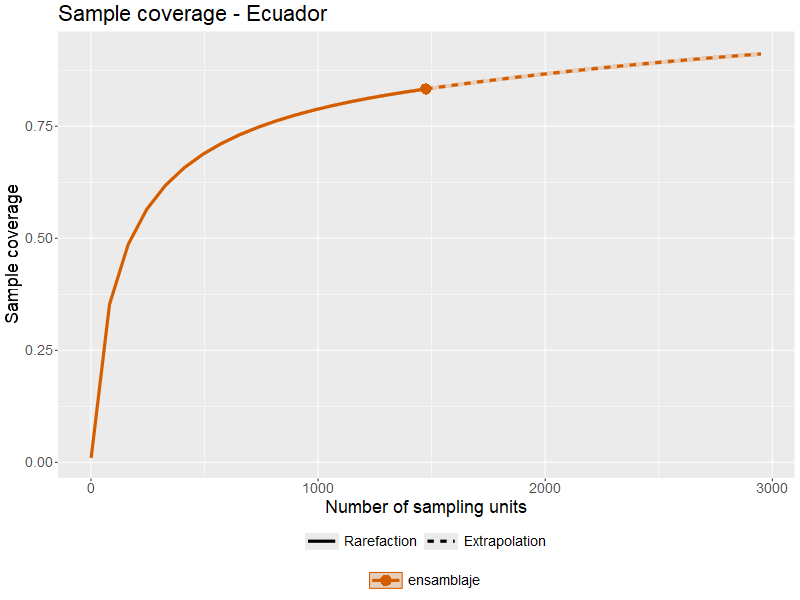

In [35]:
plot_units_sc <- ggiNEXT(result_inext_ecu, type = 2) + labs(title = "Sample coverage - Ecuador")
plot_units_sc

Warning message:
In ggiNEXT.iNEXT(result_inext_ecu, type = 1) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


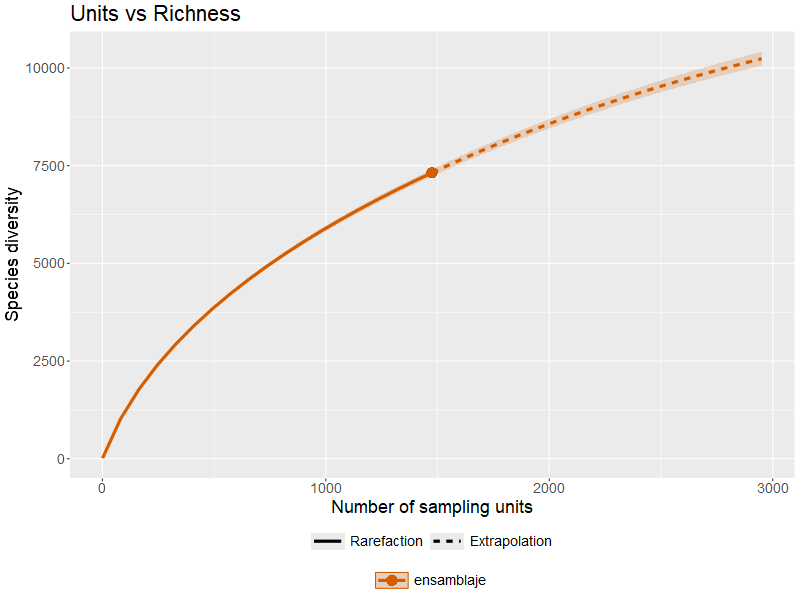

In [36]:
plot_units_richness <- ggiNEXT(result_inext_ecu, type = 1) + labs(title = "Units vs Richness")
plot_units_richness

## 6.2. Grid

### 6.2.1 Sample coverage

In [37]:
recors_grid_10km

Simple feature collection with 58572 features and 18 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -81.3037 ymin: -5.911483 xmax: -74.40273 ymax: 2.00376
Geodetic CRS:  WGS 84
First 10 features:
   id_record database_name database_id                         occurrenceID
1          2          BNDB  BNDB_10611 d7acf7c1-ac14-410f-a636-bb6568b11e49
2          4          BNDB  BNDB_10613 69a0389d-65cc-4d77-8c0e-d0ccc84ea7fb
3          6          BNDB  BNDB_10615 077e2a7f-7bd5-45fa-b755-c73a64708355
4          8          BNDB  BNDB_10617 431219fe-57b1-489b-aeba-cf5ea796076d
5         10          BNDB  BNDB_10619 51881f8d-794a-4847-9aa5-f67bfd4c110e
6         12          BNDB  BNDB_10622 6a39ade7-4d42-456e-b597-5f3f0f8bb09a
7         14          BNDB  BNDB_10624 b9a9b126-ddde-410e-8fbd-b2d202966e7e
8         16          BNDB  BNDB_10626 e7726f6f-e7f1-42d8-9389-d3df2d9c2ee1
9         18          BNDB  BNDB_10628 b66bee63-925d-470c-875f-c15e6e9825b5
10        20          BN

In [38]:
# Unique 10-km IDs
cid_10km <- unique(recors_grid_10km$id)

# Results container (abundance-based)
results_s_cov <- data.frame(
  id_10km = integer(),
  Samplig_coverage = numeric(),  # SC observado (abundancia)
  n_records = numeric(),         # n total de registros
  sp_obs = numeric(),         # S.obs
  f1 = numeric(),                # singletons
  f2 = numeric(),                # doubletons
  sc_ext = numeric(),            # SC al extremo de la curva
  n_records_ext = numeric(),     # n (size) al extremo
  sp_ext = numeric(),         # qD al extremo
  stringsAsFactors = FALSE
)

# Progress bar
pb <- txtProgressBar(min = 0, max = length(cid_10km), style = 3)
count <- 0

for (i in cid_10km) {

  # 1) Filtrar todo dentro del 10-km (SIN usar id_2km)
  records_by_id <- recors_grid_10km %>%
    dplyr::filter(id == i)

  # 2) Vector de abundancias por género (n° de registros por género)
  #    - quitar NAs en genus
  #    - quedarnos con géneros con n > 0
  abund_tbl <- records_by_id %>%
    dplyr::filter(!is.na(scientificName)) %>%
    dplyr::count(scientificName, name = "n")

  abund_vec <- abund_tbl$n
  names(abund_vec) <- abund_tbl$scientificName
  abund_vec <- abund_vec[abund_vec > 0]

  # 3) Casos sin información suficiente
  if (length(abund_vec) == 0L) {
    sampl_result <- data.frame(
      Samplig_coverage = NA_real_,
      n_records = NA_real_,
      sp_obs = NA_real_,
      f1 = NA_real_,
      f2 = NA_real_,
      sc_ext = NA_real_,
      n_records_ext = NA_real_,
      sp_ext = NA_real_,
      stringsAsFactors = FALSE
    )
  } else {
    # 4) iNEXT con abundancias (curva en función de # de registros)
    sampl_result <- tryCatch({
      res_abund <- iNEXT(
        list(ensamblaje = abund_vec),
        q = 0,
        datatype = "abundance",
        se = FALSE
      )

      # DataInfo (abundance)
      sc_obs <- res_abund$DataInfo$SC
      n_obs  <- res_abund$DataInfo$n
      s_obs  <- res_abund$DataInfo$S.obs
      f1     <- res_abund$DataInfo$f1
      f2     <- res_abund$DataInfo$f2

      # coverage_based: SC y qD al extremo (última fila)
      cb <- res_abund$iNextEst$coverage_based
      sc_ext <- if (!is.null(cb) && nrow(cb) > 0) tail(cb$SC, 1) else NA_real_
      qd_ext <- if (!is.null(cb) && nrow(cb) > 0) tail(cb$qD, 1) else NA_real_

      # size_based: n (m) al extremo (última fila)
      sb <- res_abund$iNextEst$size_based
      n_ext <- if (!is.null(sb) && nrow(sb) > 0) tail(sb$m, 1) else NA_real_

      data.frame(
        Samplig_coverage = sc_obs,
        n_records = n_obs,
        sp_obs = s_obs,
        f1 = f1,
        f2 = f2,
        sc_ext = sc_ext,
        n_records_ext = n_ext,
        sp_ext = round(qd_ext, 0),
        stringsAsFactors = FALSE
      )
    }, error = function(e) {
      data.frame(
        Samplig_coverage = NA_real_,
        n_records = NA_real_,
        sp_obs = NA_real_,
        f1 = NA_real_,
        f2 = NA_real_,
        sc_ext = NA_real_,
        n_records_ext = NA_real_,
        sp_ext = NA_real_,
        stringsAsFactors = FALSE
      )
    })
  }

  # 5) Append por celda 10-km
  results_s_cov <- rbind(
    results_s_cov,
    cbind(data.frame(id_10km = i, stringsAsFactors = FALSE), sampl_result)
  )

  count <- count + 1
  setTxtProgressBar(pb, count)
}

# Close progress bar
close(pb)



  |======================================================================| 100%

There were 50 or more warnings (use warnings() to see the first 50)


In [39]:
results_s_cov

    id_10km Samplig_coverage n_records sp_obs  f1  f2    sc_ext n_records_ext
1      1606           0.4857         7      5   4   0 0.7540187            14
2      2228           0.6755        70     39  23  10 0.8649594           140
3      2508           0.8720       593    144  76  23 0.9301537          1186
4      2868           0.3861        60     46  37   5 0.5333709           120
5      4814           0.6708       115     56  38   8 0.7845435           230
6      4907           0.6497        25     15   9   3 0.8234277            50
7      3185           0.4857         5      4   3   1 0.7620583            10
8      2145           0.5896        85     47  35   5 0.6925134           170
9      4999           0.8463      1040    301 160  52 0.9197694          2080
10     4815           0.8680      1302    367 172  71 0.9421991          2604
11     3364           1.0000        31      4   1   0 1.0000000            62
12     3619           0.6166        62     37  24   7 0.7874711 

### 6.2.4  Join Sample covergate with 10 km grid

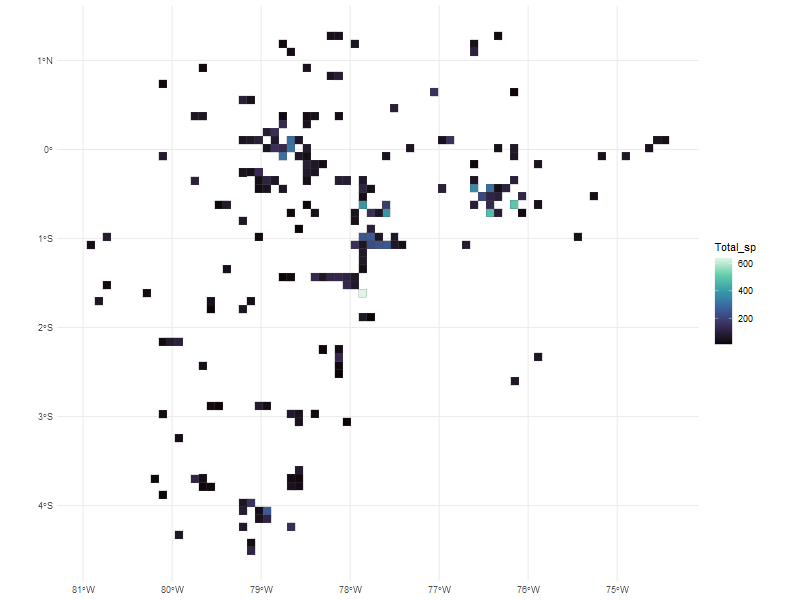

In [40]:
results_sampling_effor =  grid_10km%>%
  left_join(results_s_cov, by = "id_10km") %>% filter(Total_records >= 50 )%>%
    filter(Total_sp >= 10)

ggplot(results_sampling_effor) +
  geom_sf(aes(fill = Total_sp ), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

# 7. Exportar resultados

In [41]:

 st_write(results_sampling_effor, "Results/shp/grid_10km_samping_filter.shp", append=FALSE)

Deleting layer `grid_10km_samping_filter' using driver `ESRI Shapefile'
Writing layer `grid_10km_samping_filter' to data source 
  `Results/shp/grid_10km_samping_filter.shp' using driver `ESRI Shapefile'
Writing 198 features with 16 fields and geometry type Polygon.


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver
